In [13]:
import numpy as np
import cv2
import json
import os
import yaml
import torch
import pdb
import open3d as o3d
import matplotlib.pyplot as plt
%matplotlib inline

## For single image

In [14]:
calib_folder = './calibration'
global_config = os.path.join(calib_folder, 'defaults.yaml')
camera_config = os.path.join(calib_folder, 'cameras.yaml')
with open(global_config) as f:
    global_config_dict = yaml.safe_load(f)

with open(camera_config) as f:
    camera_config_dict = yaml.safe_load(f)
    
def cart2hom(pts_3d: np.array) -> np.array:
    n = pts_3d.shape[0]
    pts_3d_hom = np.hstack((pts_3d, np.ones((n,1))))
    return pts_3d_hom



In [15]:

#     'bytes-cafe-2019-02-07_0',
#     'clark-center-2019-02-28_0',
#     'clark-center-2019-02-28_1',
#     'clark-center-intersection-2019-02-28_0',
#     'cubberly-auditorium-2019-04-22_0',
#     'forbes-cafe-2019-01-22_0',
#     'gates-159-group-meeting-2019-04-03_0',
#     'gates-ai-lab-2019-02-08_0',
#     'gates-basement-elevators-2019-01-17_1',
#     'gates-to-clark-2019-02-28_1',
#     'hewlett-packard-intersection-2019-01-24_0',
#     'huang-2-2019-01-25_0',
#     'huang-basement-2019-01-25_0',
#     'huang-lane-2019-02-12_0',
#     'jordan-hall-2019-04-22_0',
#     'memorial-court-2019-03-16_0',
#     'meyer-green-2019-03-16_0',
#     'nvidia-aud-2019-04-18_0',
#     'packard-poster-session-2019-03-20_0',
#     'packard-poster-session-2019-03-20_1',
#     'packard-poster-session-2019-03-20_2',
#     'stlc-111-2019-04-19_0',
#     'svl-meeting-gates-2-2019-04-08_0',
#     'svl-meeting-gates-2-2019-04-08_1',
#     'tressider-2019-03-16_0',
#     'tressider-2019-03-16_1',
#     'tressider-2019-04-26_2'


In [606]:
sensor = "sensor_8"
h, w = 480,752
K = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['K'][:-1].split()]).reshape(3,3)
R = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['R'][:-1].split()]).reshape(3,3)
T = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['T'].split()]).reshape(3,1)/1000
D = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['D'].split()])


loc = 'gates-ai-lab-2019-02-08_0'
data_root = "/home/tho/datasets/JRDB2022/train_dataset_with_activity"
if not os.path.isdir(data_root) and loc != "bytes-cafe-2019-02-07_0":
    print("please download JRDB22 data and specify the data_root")
    print("using default config")
    data_root = "."
    loc = "bytes-cafe-2019-02-07_0"

pcd = o3d.io.read_point_cloud(f"{data_root}/pointclouds/upper_velodyne/{loc}/000000.pcd")
image = cv2.imread(f"{data_root}/images/image_{sensor[-1]}/{loc}/000000.jpg")

points_3d = np.array(pcd.points)
points = torch.from_numpy(points_3d)

# Velodyne to reference coordinate
translation = torch.tensor([0,0,0.13]) # this 0.175 needs further calibration
points[:, :3] = points[:, :3] + translation 
#     - torch.Tensor(global_config_dict['calibrated']['lidar_upper_to_rgb']['translation']).type(points.type()) \

theta = 1.31 # needs further calibration
# global_config_dict['calibrated']['lidar_upper_to_rgb']['rotation'][-1] + 1.23 # needs further calibration
        
rotation_matrix = torch.Tensor([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]).type(
    points.type())
points[:, :2] = torch.matmul(rotation_matrix, points[:, :2].unsqueeze(2)).squeeze()

# move to camera world coordinates
points = points[:, [1, 2, 0]]
points[:, 0] *= -1
points[:, 1] *= -1


In [607]:
hom_points = cart2hom(points)

RT = np.vstack([np.hstack((R,T)), [0,0,0,1]])

pts_ref = np.dot(RT, np.transpose(hom_points))
pts_ref = np.transpose(pts_ref)
pts_ref = pts_ref[pts_ref[:,2]>0]


# for 3D visualisation
# pc = o3d.geometry.PointCloud()
# pc.points = o3d.utility.Vector3dVector(pts_ref[:,:3])
# mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
#     size=0.6, origin=[0,0,0])
# o3d.visualization.draw_geometries([pc])

In [608]:
x, y = pts_ref[:,0]/pts_ref[:,2], pts_ref[:,1]/pts_ref[:,2]

In [609]:
# Calculate radial distortion
k1,k2,k3,k4,k5 = D
k6 = 0

r2 = x**2 + y**2
r4 = r2**2
r6 = r2 * r4
# rad_dist = (1 + k4*r2 + k5*r4 + k6*r6) / (1 + k1*r2 + k2*r4 + k3*r6)
rad_dist = (1 + k1*r2 + k2*r4 + k3*r6) 
# Get intrinsics params
fx, _, cx = K[0]
_, fy, cy = K[1]
# Apply radial distortion and intrinsic parameters
xd = fx * x * rad_dist + cx
yd = fy * y * rad_dist + cy
# Get the 2D points
pts_2d = np.stack([xd,yd]).transpose()

In [610]:
# newcameramtx, roi = cv2.getOptimalNewCameraMatrix(K, D, (w,h), 1, (w,h))
# intrinsic[:3,:3] = newcameramtx

# intrinsic = np.zeros([3,4])
# intrinsic[:3,:3] = K

# pts_2d = np.dot(intrinsic, np.transpose(pts_ref))
# pts_2d = np.transpose(pts_2d)

# pts_2d[:, 0] /= pts_2d[:, 2]
# pts_2d[:, 1] /= pts_2d[:, 2]
# pts_2d = pts_2d[:, 0:2]

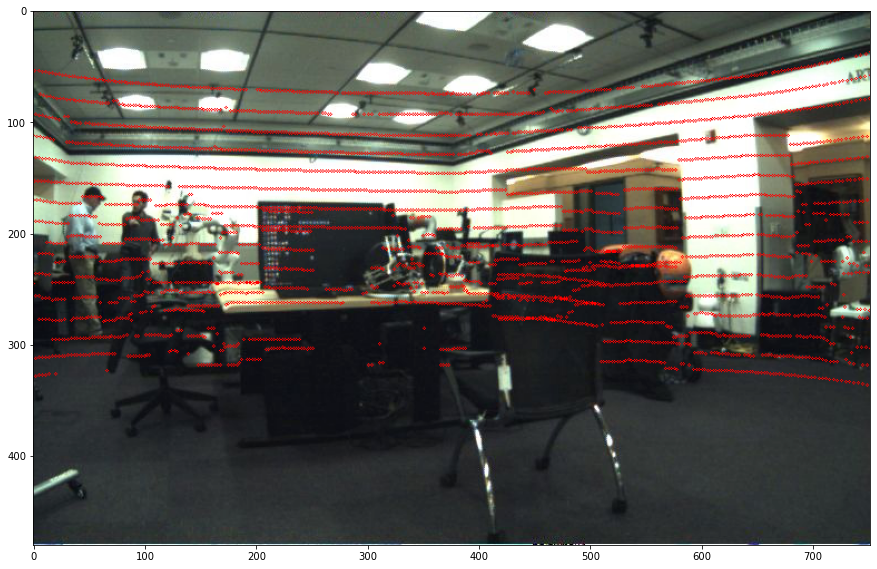

In [611]:
# Visualize
plt.figure(figsize=(15, 10))
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
for pts in pts_2d:
    if (0<pts[0]<1000) and (0<pts[1]<1000):
        cv2.circle(hsv_image, (int(pts[0]), int(pts[1])), 1, (0, 255, 255), 1)
hsv_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
plt.imshow(hsv_image)